# Coursera Capstone Project

#### Opening a Indian Restaurant in Manhattan,New York

* Build a dataframe of neighborhoods in New York, USA by using the data set availabale on https://geo.nyu.edu/catalog/nyu_2451_34572
* Get the geographical coordinates of the neighborhoods
* Obtain Manhattan Boroughs using the geocode
* Obtain the venue data for the neighborhoods from Foursquare API
* Explore and cluster the neighborhoods
* Select the best cluster to open a new Indian Restaurant


#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
! pip install geopy

In [2]:
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

In [3]:
! pip install folium

     |████████████████████████████████| 102kB 11.1MB/s ta 0:00:01


In [4]:
import folium

print('Libraries imported.')

Libraries imported.


#### Downloading the Dataset

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


#### Exploring the datase

Download and Explore Dataset Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood

In [6]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
print(neighborhoods_data)

[{'type': 'Feature', 'id': 'nyu_2451_34572.1', 'geometry': {'type': 'Point', 'coordinates': [-73.84720052054902, 40.89470517661]}, 'geometry_name': 'geom', 'properties': {'name': 'Wakefield', 'stacked': 1, 'annoline1': 'Wakefield', 'annoline2': None, 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.84720052054902, 40.89470517661, -73.84720052054902, 40.89470517661]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.2', 'geometry': {'type': 'Point', 'coordinates': [-73.82993910812398, 40.87429419303012]}, 'geometry_name': 'geom', 'properties': {'name': 'Co-op City', 'stacked': 2, 'annoline1': 'Co-op', 'annoline2': 'City', 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.82993910812398, 40.87429419303012, -73.82993910812398, 40.87429419303012]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.3', 'geometry': {'type': 'Point', 'coordinates': [-73.82780644716412, 40.887555677350775]}, 'geometry_name': 'geom', 'properties': {'name': 'Eastchester', 'stacked': 1

#### Transform dataset into pandas

In [7]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
print(neighborhoods.head())

  Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585


In [9]:
print(neighborhoods.shape)

(306, 4)


#### Getting dataset for Manhattan

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [11]:
manhattan_data.Neighborhood.unique

<bound method Series.unique of 0             Marble Hill
1               Chinatown
2      Washington Heights
3                  Inwood
4        Hamilton Heights
5          Manhattanville
6          Central Harlem
7             East Harlem
8         Upper East Side
9               Yorkville
10             Lenox Hill
11       Roosevelt Island
12        Upper West Side
13         Lincoln Square
14                Clinton
15                Midtown
16            Murray Hill
17                Chelsea
18      Greenwich Village
19           East Village
20        Lower East Side
21                Tribeca
22           Little Italy
23                   Soho
24           West Village
25       Manhattan Valley
26    Morningside Heights
27               Gramercy
28      Battery Park City
29     Financial District
30          Carnegie Hill
31                   Noho
32           Civic Center
33          Midtown South
34           Sutton Place
35             Turtle Bay
36             Tudor City
37     

#### Use Geopy for location

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Import Folium 

Mark the neighborhods of New York on the Folium Map

In [13]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11.4)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=5,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Use GeoCode to find the coordinate of Manhattan, NY

In [14]:
address = 'Manhattan, New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
manhat_latitude = location.latitude
manhat_longitude = location.longitude
radius=5000
print('The geograpical coordinate of Manhattan  are {}, {}.'.format(manhat_latitude, manhat_longitude))

The geograpical coordinate of Manhattan  are 40.7896239, -73.9598939.


#### Use the FOURSQUARE API to get Venue

Search top 500 Indain Restaurant using the Foursquare API and get the location of the Indian Restaurants within the radius of 5 km

In [15]:
CLIENT_ID = 'DIQS0ZLMYHDNXPZCKF4RZNQB2BSBCXOY1LBEDGUK2G3VDG3A' # your Foursquare ID
CLIENT_SECRET = 'GNRMVGQGXSE1AWXQNZSXWLFZQ1MXD3B15F4EEZDTFNGB5LY4' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
search_query = 'Indian Restaurants'

In [16]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, manhat_latitude, manhat_longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=DIQS0ZLMYHDNXPZCKF4RZNQB2BSBCXOY1LBEDGUK2G3VDG3A&client_secret=GNRMVGQGXSE1AWXQNZSXWLFZQ1MXD3B15F4EEZDTFNGB5LY4&ll=40.7896239,-73.9598939&v=20180604&query=Indian Restaurants&radius=5000&limit=500'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec4f359963d29001b5315bf'},
 'response': {'venues': [{'id': '4f32a9c119836c91c7eda319',
    'name': 'Indian Restaurant',
    'location': {'address': '338 9th Ave',
     'lat': 40.750702,
     'lng': -73.9981,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.750702,
       'lng': -73.9981}],
     'distance': 5398,
     'postalCode': '10001',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['338 9th Ave',
      'New York, NY 10001',
      'United States']},
    'categories': [{'id': '4d4b7105d754a06374d81259',
      'name': 'Food',
      'pluralName': 'Food',
      'shortName': 'Food',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1589966058',
    'hasPerk': False},
   {'id': '4c6ec437c52437042cf42beb',
    'name': 'Indian fast food cart',
    'location': {'addre

#### Convert Dataset to Pandas DataFrame

In [18]:
neighborhood_data = results['response']['venues']
# define the dataframe columns
column_names = ["Venue","Latitude","Longitude"]
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [19]:
for data in neighborhood_data:
    venue =data['name']
    venue_lat = data['location']['lat']
    venue_lon = data['location']['lng']
    neighborhoods = neighborhoods.append({'Venue': venue,'Latitude': venue_lat,
                                          'Longitude': venue_lon}, ignore_index=True)

In [20]:
print(neighborhoods.head())

                             Venue   Latitude  Longitude
0                Indian Restaurant  40.750702 -73.998100
1            Indian fast food cart  40.759469 -73.972256
2  Indian Project - Broadway Bites  40.749850 -73.987908
3                    Indian Summer  40.805740 -73.947320
4                   Indian Tanpura  40.788515 -73.974405


#### ETL

Removing those restaurants with NAN values instead of names

In [21]:
neighborhoods.dropna(subset=["Venue"])

,Venue,Latitude,Longitude
0,Indian Restaurant,40.750702,-73.998100
1,Indian fast food cart,40.759469,-73.972256
2,Indian Project - Broadway Bites,40.749850,-73.987908
3,Indian Summer,40.805740,-73.947320
4,Indian Tanpura,40.788515,-73.974405
5,The Indian Hunter,40.770372,-73.973352
6,Mughlai Indian Cuisine,40.780206,-73.950088
7,Indian Coral,40.805885,-73.929228
8,Indian Rugs,40.762081,-73.964542
9,indian Temple,40.812111,-73.952270


Replacing the NAN values for Restaurants coordinates in Manhattan dataset with Latitude and Longitude of the Manhattan,NY


In [22]:
neighborhoods["Latitude"].fillna(40.7896239, inplace = True) 
neighborhoods["Longitude"].fillna( 40.7896239,inplace=True)


Cleaned dataset after Feature Engineering

In [24]:
print(neighborhoods.head())

                             Venue   Latitude  Longitude
0                Indian Restaurant  40.750702 -73.998100
1            Indian fast food cart  40.759469 -73.972256
2  Indian Project - Broadway Bites  40.749850 -73.987908
3                    Indian Summer  40.805740 -73.947320
4                   Indian Tanpura  40.788515 -73.974405


#### Creating the Map for Manhattan Dataset

In [25]:
import folium
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[venue_lat, venue_lon], zoom_start=13)

# add markers to map
for lat, lng,venue in zip(neighborhoods['Latitude'],neighborhoods['Longitude'], neighborhoods['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=5,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Importing KMeans for Clustering of the Restaurants

In [26]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
 
%matplotlib inline

In [27]:
manhattan_cluster=neighborhoods.drop("Venue",axis=1)

#### Using the Elbow Method to chech the best Clusters for the dataset Clustering

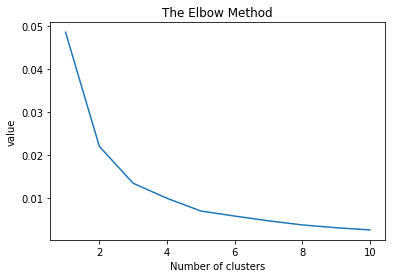

In [28]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(manhattan_cluster)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('value')
plt.show()

In [29]:
k_means = KMeans( n_clusters = 4, n_init = 12)

In [46]:
# run k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(manhattan_cluster)

k_means_labels = kmeans.labels_
k_means_label = pd.DataFrame({'Labels': k_means_labels})
labels=k_means_label.values
labels.size

50

#### Adding Labels to each venue

In [47]:
# add clustering labels
frames=[k_means_label,neighborhoods]
manhattan_merged=pd.concat([k_means_label,neighborhoods],axis=1,sort=True)

manhattan_merged.head()

,Labels,Venue,Latitude,Longitude
0,2,Indian Restaurant,40.750702,-73.998100
1,3,Indian fast food cart,40.759469,-73.972256
2,2,Indian Project - Broadway Bites,40.749850,-73.987908
3,1,Indian Summer,40.805740,-73.947320
4,3,Indian Tanpura,40.788515,-73.974405


#### Generating the Folium Map and showing the clusters

In [32]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [33]:
base_map = generateBaseMap()

In [34]:
# create map
base_map.add_child(folium.ClickForMarker(popup='Potential Location'))
map_clusters = folium.Map(location=[venue_lat, venue_lon], zoom_start=12)
manhatt=[manhat_latitude,manhat_longitude]
# set color scheme for the clusters
rainbow = ["blue","red","green","orange"]

#add markers to the map

markers_colors = []
for lat, lon, veu, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Venue'], manhattan_merged['Labels']):
    label = folium.Popup(str(veu) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Analysing the Clusters

##### Cluster 0

In [35]:
cluster0=manhattan_merged.loc[manhattan_merged["Labels"]==0].shape[0]
cluster0

5

#####  Cluster 1 

In [38]:
cluster1=manhattan_merged.loc[manhattan_merged["Labels"]==1].shape[0]
cluster1

10

##### CLuster 2

In [37]:
cluster2=manhattan_merged.loc[manhattan_merged["Labels"]==2].shape[0]
cluster2

19

##### Cluster 3

In [39]:
cluster3=manhattan_merged.loc[manhattan_merged["Labels"]==3].shape[0]
cluster3

16

In [51]:

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of restaurants is each clusters')

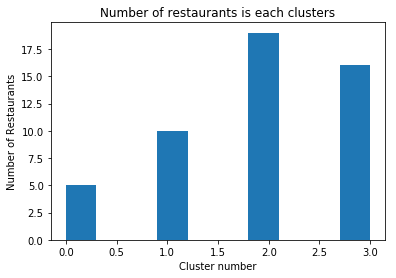

In [79]:
plt.hist(labels,histtype="bar")
plt.xlabel("Cluster number")
plt.ylabel("Number of Restaurants")
plt.title("Number of restaurants is each clusters")

### Observations

Most of the Indian Restaurants are concentrated in the west of Manhattan , with the highest number in cluster 2 and moderate number in cluster 3. On the other hand, cluster 0 has very low number to totally no Indian restaurants in the neighborhoods. This represents a great opportunity and high potential areas to open new Indian Restaurants as there is very little to no competition from existing restaurants Meanwhile,restaurants in cluster 2 are likely suffering from intense competition due to oversupply and high concentration of restaurants. From another perspective, this also shows that the oversupply ofindian restaurants mostly happened due to more Indians living in the  premisies. Therefore, this project recommends the client to capitalize on these findings to open new Indian Restaurant in neighborhoods in cluster 0 with little to no competition. Clients with unique selling propositions to stand out from the competition can also open new Indian Restaurants in neighborhoods in cluster 1 with moderate competition. Lastly, clients are advised to avoid neighborhoods in cluster 2 which already have high concentration of Indian Restaurants and suffering from intense competition.